# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import neighbors as nh
import scikitplot as skplt
from sklearn.metrics import top_k_accuracy_score, accuracy_score#, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit as sss

import xgboost as xgb

## 0.1 Load data

In [2]:
df_train_res = pd.read_pickle("data_in_progress/df_train_res_nn.pkl")

df_val = pd.read_pickle("data_in_progress/df_val.pkl")

cols_selected_boruta_resampled = pickle.load(open("data_in_progress/cols_selected_boruta_resampled_nn.pkl", "rb"))

In [3]:
cols_selected_boruta_resampled

['age', 'region_code', 'previously_insured', 'annual_premium', 'vintage']

In [4]:
resp = ['response']
cols_selected_boruta_resampled_full = cols_selected_boruta_resampled.copy()
cols_selected_boruta_resampled_full.extend(resp)

## 0.2 Separate train and validation data

In [5]:
df7 = df_train_res[cols_selected_boruta_resampled_full].copy()

In [6]:
X_train_res = df7.drop(['response'], axis=1)
y_train_res = df7.response

In [7]:
df7_val = df_val[cols_selected_boruta_resampled_full].copy()

In [8]:
X_val = df7_val.drop(['response'], axis=1)
y_val = df7_val.response

## 0.3 Helper Functions

In [9]:
# model metrics
def model_metrics(model, model_name, data_train, data_val, proba_tresh=0.5):
    # separate X and Y data:
    xtrain = data_train.drop(['response'], axis=1)
    ytrain = data_train.response
    xval = data_val.drop(['response'], axis=1)
    yval = data_val.response
    
    # fit and predict_proba:
    model.fit(xtrain, ytrain)
    yhat_proba = model.predict_proba(xval)
    
    # transform yhat_proba to 1D-array
    yhat_proba_1d = np.array([1 if yhat_proba[i, 1] > proba_tresh else 0
                              for i in range(yhat_proba.shape[0])])
    
    # plot
    skplt.metrics.plot_cumulative_gain(yval, yhat_proba);
    
    return pd.DataFrame({'Model name':model_name,
                         'accuracy':"{:.4f}".format(top_k_accuracy_score(yval, yhat_proba_1d, k=1))}, index=[0])



def cross_validation(model, model_name, training_data, kfolds, proba_tresh=0.5, verbose=False):
    # X separate X and Y data:
    xtraining = training_data.drop(['response'], axis=1)
    ytraining = training_data.response
    
    # cross-validation:
    cv = sss(n_splits=kfolds)
    acc_list = []
    for train_index, prim_val_index in cv.split(xtraining, ytraining):
        X_training, X_prim_val = xtraining.iloc[train_index], xtraining.iloc[prim_val_index]
        y_training, y_prim_val = ytraining.iloc[train_index], ytraining.iloc[prim_val_index]
        
        # fit and predict_proba
        model.fit(X_training, y_training)
        yhat_proba = model.predict_proba(X_prim_val)
        
        # transform yhat_proba to 1D-array
        yhat_proba_1d = np.array([1 if yhat_proba[i, 1] > proba_tresh else 0
                                  for i in range(yhat_proba.shape[0])])
        
        # evaluate accuracy and store in list
        acc_list.append(top_k_accuracy_score(y_prim_val, yhat_proba_1d, k=1))
    
    #evaluate mean and std
    acc_pred = np.round(np.mean(acc_list), 4).astype(str) + '+/-' + np.round(np.std(acc_list), 4).astype(str)
    
    return pd.DataFrame({'Model name':model_name,
                         'accuracy':acc_pred}, index=[0])

# 7.0 Machine Learning Model

## 7.1 Features selected by Boruta

### 7.1.1 Logistic Classifier

,Model name,accuracy
0,Logistic Regression Classifier,0.5801


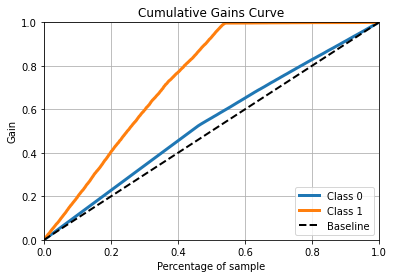

In [10]:
model_logreg = LogReg(random_state=30, solver='saga', n_jobs=-1)

logreg_metrics = model_metrics(model_logreg, "Logistic Regression Classifier", df7, df7_val)

logreg_metrics

### 7.1.2 KNN

,Model name,accuracy
0,Nearest Neighbors Classifier,0.6495


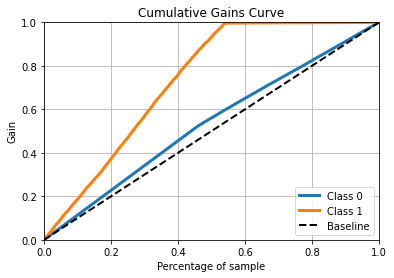

In [11]:
model_knn = nh.KNeighborsClassifier(n_neighbors=20)

knn_metrics = model_metrics(model_knn, "Nearest Neighbors Classifier", df7, df7_val)

knn_metrics

### 7.1.3 Random Forest Classifier

,Model name,accuracy
0,Random Forest Classifier,0.6362


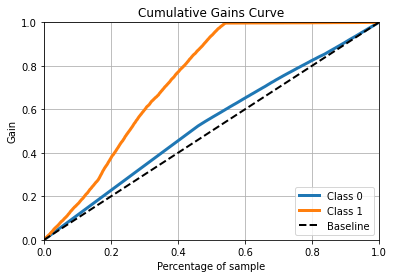

In [12]:
model_rf = RF(n_estimators=500, max_depth=10, random_state=30, n_jobs=-1)

rf_metrics = model_metrics(model_rf, "Random Forest Classifier", df7, df7_val)

rf_metrics

### 7.1.4 XGBoost Classifier

,Model name,accuracy
0,XGBoost Classifier,0.6545


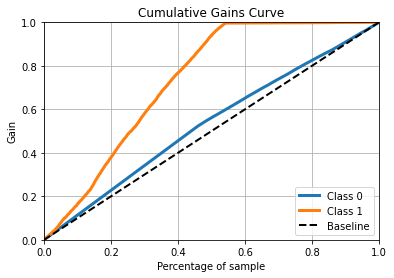

In [13]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              verbosity=0)

xgb_metrics = model_metrics(model_xgb, "XGBoost Classifier", df7, df7_val)

xgb_metrics

## 7.2 Cross-validation

### 7.2.1 Logistic Regression

In [14]:
model_logreg = LogReg(random_state=30, solver='saga', n_jobs=-1)

logreg_cv_metrics = cross_validation(model_logreg, "Logistic Regression Classifier", df7, 5)

logreg_cv_metrics

,Model name,accuracy
0,Logistic Regression Classifier,0.7444+/-0.0014


### 7.2.2 KNN

In [15]:
model_knn = nh.KNeighborsClassifier(n_neighbors=50, n_jobs=-1)

knn_cv_metrics = cross_validation(model_knn, "Nearest Neighbors Classifier", df7, 5)

knn_cv_metrics

,Model name,accuracy
0,Nearest Neighbors Classifier,0.8052+/-0.0009


### 7.2.3 Random Forest Classifier

In [16]:
model_rf = RF(n_estimators=100, max_depth=10, random_state=30, n_jobs=-1)

rf_cv_metrics = cross_validation(model_rf, "Random Forest Classifier", df7, 5)

rf_cv_metrics

,Model name,accuracy
0,Random Forest Classifier,0.8118+/-0.0034


### 7.2.4 XGBoost Classifier

In [17]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              min_child_weight=1,
                              verbosity=0)

xgb_cv_metrics = cross_validation(model_xgb, "XGBoost Classifier", df7, 5)

xgb_cv_metrics

,Model name,accuracy
0,XGBoost Classifier,0.8154+/-0.0014


# 8.0 Hyperparameter Fine Tunning

## 8.1 XGBoost Classifier

In [18]:
param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
         'eta':[0.01, 0.03],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15],
        }

MAX_EVAL = 5

In [19]:
final_result = pd.DataFrame()
hyperparam_lst = []

for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
    #print the selected ones
    print(hp)
    #store in list
    hyperparam_lst.append(hp.copy())
    #model
    model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                  use_label_encoder=False,
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  n_jobs=-1,
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                  verbosity=0)
    result = cross_validation(model_xgb, 'XGBoost Classifier', df7, 5)
    iter_nr = pd.Series([i], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    final_result = pd.concat([final_result, result_w_nr], ignore_index=True)

final_result.sort_values(by=['accuracy'], ascending=False, inplace=True, ignore_index=True)
final_result

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}


,Model name,accuracy,Iter_nr
0,XGBoost Classifier,0.8191+/-0.002,0
1,XGBoost Classifier,0.8171+/-0.0012,1
2,XGBoost Classifier,0.8126+/-0.0012,2
3,XGBoost Classifier,0.8112+/-0.0012,4
4,XGBoost Classifier,0.811+/-0.0016,3


In [20]:
final_result.to_pickle('data_in_progress/xgb_tunning_acc_cv.pkl')

In [21]:
# select the hyperparameters that resulted in best accuracy
best_param_nr = final_result.loc[0, 'Iter_nr']

param_tuned = hyperparam_lst[best_param_nr]

In [22]:
#model
model_xgb_tuned = xgb.XGBClassifier(objective='binary:logistic',
                                    use_label_encoder=False,
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    n_jobs=-1,
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    verbosity=0)

,Model name,accuracy
0,XGBoost Classifier,0.6592


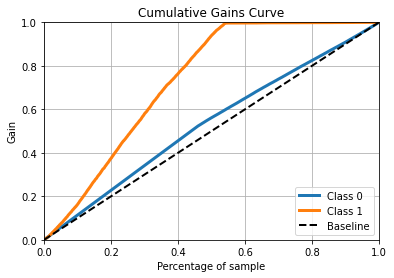

In [23]:
xgb_tuned_metrics = model_metrics(model_xgb_tuned, "XGBoost Classifier", df7, df7_val)

xgb_tuned_metrics

In [24]:
model_xgb_tuned.save_model('data_in_progress/model_xgb_tuned_acc.json')

In [25]:
pickle.dump(xgb_tuned_metrics, open("data_in_progress/xgb_tuned_metrics.pkl", "wb"))